In [ ]:
library(tidyverse)
library(igraph)
library(ggplot2)
library(geodist)
library(zipcodeR)
library(glmnet)
library(pls)
library(leaps)
library(class)
library(tree)
library(readr)
library("dplyr")
library("ggpubr")

# Regression between sci and distance

In [ ]:
ZIP <- read.table("C:/Users/86156/Desktop/Data Project/Zip/zcta_zcta_shard1.tsv", header=T, sep="\t")

In [ ]:
ZIP_PA <- ZIP %>% 
  filter(user_loc %in% 15001:19612 & fr_loc %in% 15001:19614) %>%
  distinct(scaled_sci,.keep_all = TRUE)

ZIP_PA_DISTANCE <- ZIP_PA %>% 
  mutate(zip_distance(user_loc, fr_loc)) %>%
  select(user_loc,fr_loc,scaled_sci,distance)
  
  
ZIP_DATA <- as.data.frame(reverse_zipcode(ZIP_PA_DISTANCE$user_loc))

ZIP_DATA_COUNTY <- ZIP_DATA %>%
  select(zipcode, county)

ZIP_COUNTY <- merge(ZIP_PA_DISTANCE,ZIP_DATA_COUNTY, by.x = 'user_loc', by.y = 'zipcode')
ZIP_COUNTY <- merge(ZIP_COUNTY,ZIP_DATA_COUNTY, by.x = 'fr_loc', by.y = 'zipcode')
ZIP_COUNTY <- plyr::rename(ZIP_COUNTY, c('county.x'='user_county', 'county.y'='fr_county'))

In [ ]:
ggplot(ZIP_COUNTY,aes(distance,scaled_sci)) +
  geom_jitter(height = 2, width = 2)

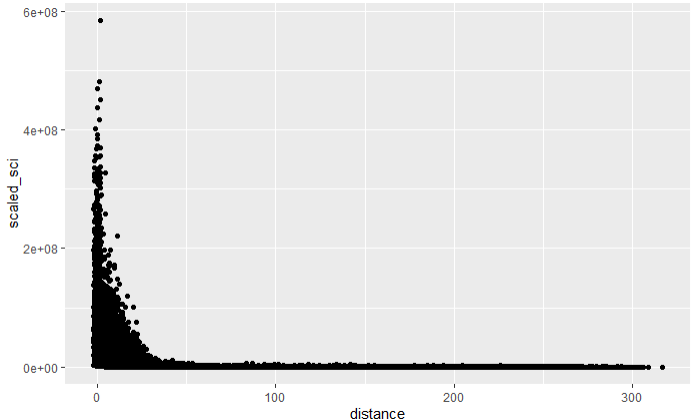

In [ ]:
ZIP_LOG_DISTANCE <- ZIP_PA_DISTANCE %>%
  mutate(log_sci = log(scaled_sci), log_distance = log(distance)) %>%
  select(-scaled_sci, -distance)

ZIP_LOG_DISTANCE <- ZIP_LOG_DISTANCE[!is.infinite(ZIP_LOG_DISTANCE$log_distance), ]

In [ ]:
lm2 = lm(log_sci~log_distance, data = ZIP_LOG_DISTANCE)
summary(lm2)

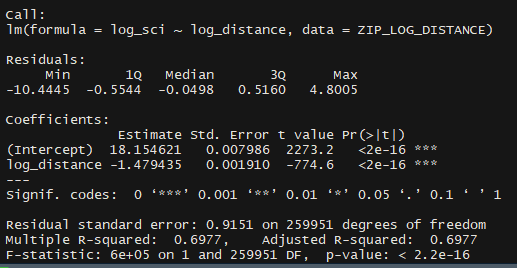

In [ ]:
u_r <- read.csv("C:/Users/86156/Desktop/Data Project/urban_rural.csv")

ZIP_UR <- merge(ZIP_COUNTY,u_r, by.x = 'user_county', by.y = 'County')
ZIP_UR <- merge(ZIP_UR,u_r, by.x = 'fr_county', by.y = 'County')

ZIP_UR <- plyr::rename(ZIP_UR, c('U_R.x'='ur_user','U_R.y'='ur_fr'))

ZIP_UR$ur_user[ZIP_UR$ur_user=="Rural"] = -1
ZIP_UR$ur_user[ZIP_UR$ur_user=="Urban"] = 1
ZIP_UR$ur_fr[ZIP_UR$ur_fr=="Rural"] = -1
ZIP_UR$ur_fr[ZIP_UR$ur_fr=="Urban"] = 1

ZIP_UR$ur_user <- as.numeric(ZIP_UR$ur_user)
ZIP_UR$ur_fr <- as.numeric(ZIP_UR$ur_fr)

ZIP_UR <- ZIP_UR %>%
  mutate('corelation' = ur_user+ur_fr)

ZIP_UR$corelation <- as.factor(ZIP_UR$corelation)

In [ ]:
ggplot(ZIP_UR, aes(x=corelation , y = log(scaled_sci))) +
  geom_boxplot()

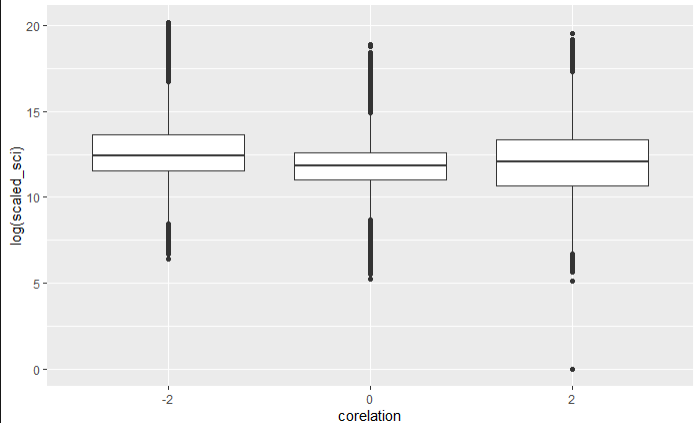

In [ ]:
ZIP_LOG_UR <- ZIP_UR %>%
  mutate(log_sci = log(scaled_sci), log_distance = log(distance)) %>%
  select(-scaled_sci, -distance)

ZIP_LOG_UR <- ZIP_LOG_UR[!is.infinite(ZIP_LOG_UR$log_distance), ]


ggscatter(ZIP_LOG_UR, x ="log_distance", y ="log_sci",
          color = "corelation", shape = 21, size = 2,
          add = "reg.line", conf.int = TRUE,
          cor.coef = TRUE, cor.method = "pearson", 
          xlab = "log_distance", ylab = "log_sci")

reg <- lm(log_sci~log_distance+corelation, data = ZIP_LOG_UR)
summary(reg)

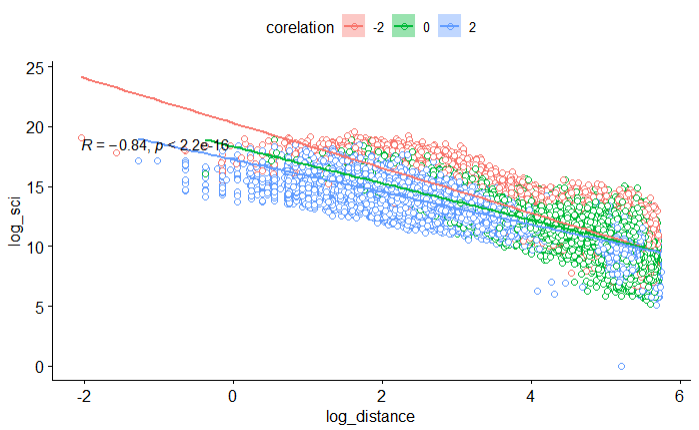

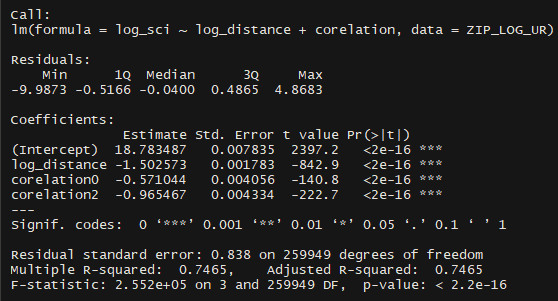

# Regression with Rural & Urban impact

In [ ]:
#dataset generation between rural and urban
rural_rural <- ZIP_LOG_UR %>%
  filter(ZIP_LOG_UR$corelation == -2)
urban_urban <- ZIP_LOG_UR %>%
  filter(ZIP_LOG_UR$corelation == 2)
rural_urban <- ZIP_LOG_UR %>%
  filter(ZIP_LOG_UR$corelation == 0)

In [ ]:
#if both users are coming from rural
ggscatter(rural_rural, x ="log_distance", y ="log_sci",
          color = "red", shape = 21, size = 2,
          add = "reg.line", conf.int = TRUE,
          cor.coef = TRUE, cor.method = "pearson", 
          xlab = "log_distance", ylab = "log_sci")

reg_rural_rural <- lm(log_sci ~ log_distance, data = rural_rural)
summary(reg_rural_rural)

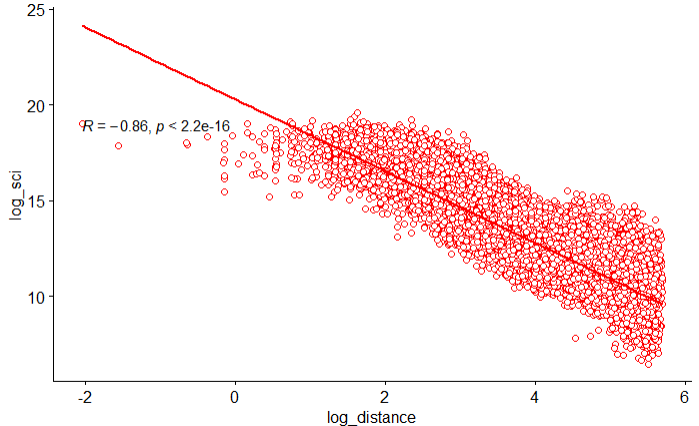

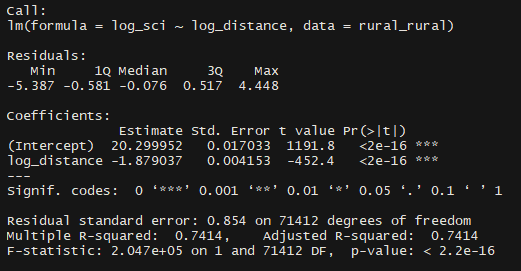

In [ ]:
#if both users are coming from urban
ggscatter(urban_urban, x ="log_distance", y ="log_sci",
          color = "blue", shape = 21, size = 2,
          add = "reg.line", conf.int = TRUE,
          cor.coef = TRUE, cor.method = "pearson", 
          xlab = "log_distance", ylab = "log_sci")

reg_urban_urban <- lm(log_sci ~ log_distance, data = urban_urban)
summary(reg_urban_urban)

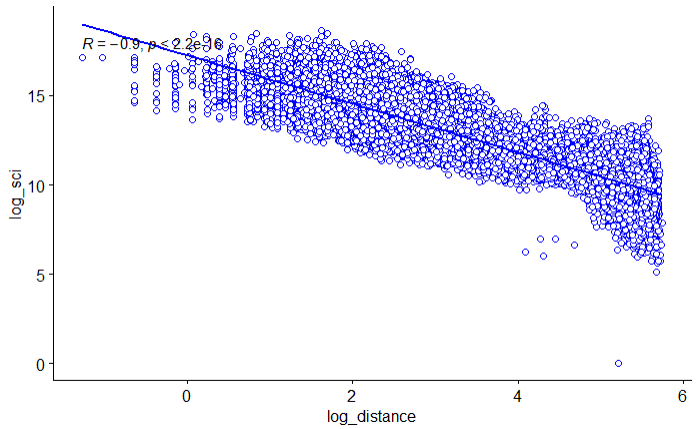

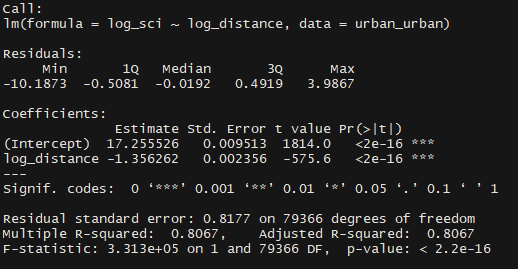

In [ ]:
#if the users are coming from urban and rural
ggscatter(rural_urban, x ="log_distance", y ="log_sci",
          color = "green", shape = 21, size = 2,
          add = "reg.line", conf.int = TRUE,
          cor.coef = TRUE, cor.method = "pearson", 
          xlab = "log_distance", ylab = "log_sci")

reg_rural_urban <- lm(log_sci ~ log_distance, data = rural_urban)
summary(reg_rural_urban)

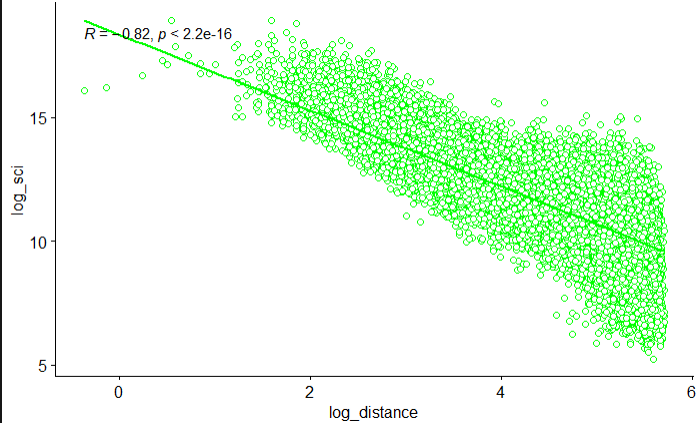

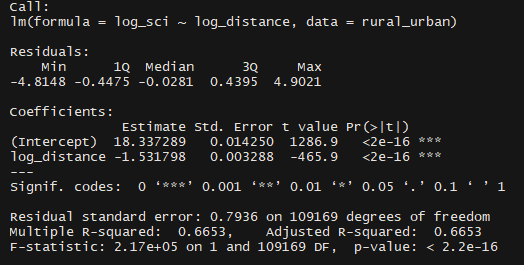

# Regression of distance, income difference, population density difference and correlation

In [ ]:
ZIP_DATA_INCOME <- ZIP_DATA %>%
  select(zipcode, median_household_income)

ZIP_INCOME <- merge(ZIP_PA,ZIP_DATA_INCOME, by.x = 'user_loc', by.y = 'zipcode')
ZIP_INCOME <- merge(ZIP_INCOME,ZIP_DATA_INCOME, by.x = 'fr_loc', by.y = 'zipcode')
ZIP_INCOME<- plyr::rename(ZIP_INCOME, c('median_household_income.x'='user_income', 'median_household_income.y'='fr_income'))

ZIP_INCOME <- ZIP_INCOME %>%
  mutate(income_diff = abs(user_income-fr_income))

In [ ]:
ggplot(ZIP_INCOME, aes(x=income_diff , y = scaled_sci)) +
  geom_jitter()+scale_x_log10()

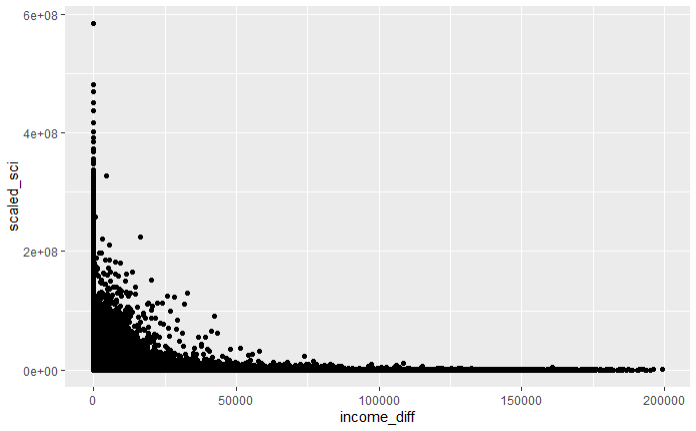

In [ ]:
ZIP_DATA_DENSITY <- ZIP_DATA %>%
  select(zipcode, population_density)

ZIP_DENSITY <- merge(ZIP_PA,ZIP_DATA_DENSITY, by.x = 'user_loc', by.y = 'zipcode')
ZIP_DENSITY <- merge(ZIP_DENSITY,ZIP_DATA_DENSITY, by.x = 'fr_loc', by.y = 'zipcode')
ZIP_DENSITY<- plyr::rename(ZIP_DENSITY, c('population_density.x'='user_density', 'population_density.y'='fr_density'))

ZIP_DENSITY <- ZIP_DENSITY %>%
  mutate(density_diff = abs(user_density-fr_density))

In [ ]:
ggplot(ZIP_DENSITY, aes(x=density_diff , y = scaled_sci)) +
  geom_jitter()

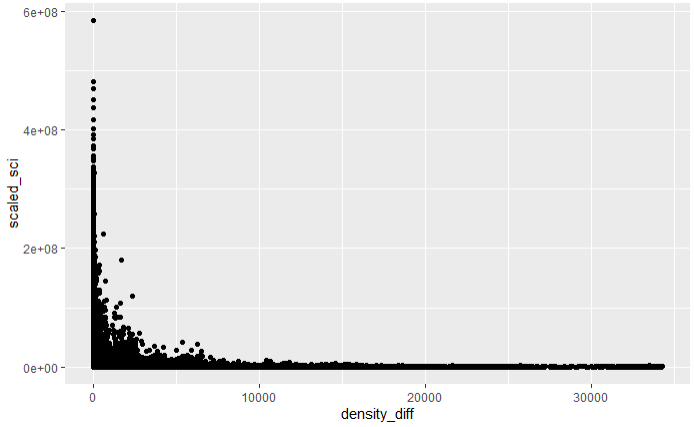

In [ ]:
ZIP_THREE <- merge(ZIP_PA_DISTANCE, ZIP_INCOME)
ZIP_THREE <- merge(ZIP_THREE, ZIP_DENSITY) %>%
  select(user_loc, fr_loc, scaled_sci, distance, income_diff, density_diff)

ZIP_THREE <- ZIP_THREE %>%
  mutate(log_sci = log(scaled_sci), log_distance = log(distance)) %>%
  select(-scaled_sci, -distance)

ZIP_UR_1 <- ZIP_UR %>%
  select(user_loc, fr_loc, corelation)

ZIP_FOUR <- merge(ZIP_THREE,ZIP_UR_1)

ZIP_FOUR <- ZIP_FOUR[!is.infinite(ZIP_FOUR$log_distance), ]

In [ ]:
lm1 = lm(log_sci~log_distance+income_diff+density_diff+corelation, data = ZIP_FOUR)
summary(lm1)

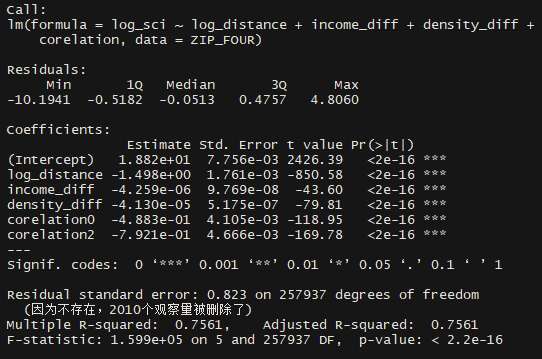

# SCI Network Plot
The points in this plot are located by the latitude and longitude of the center point of the corresponding county. The widths of the line segments represent the sizes of the SCI between the two counties. The threshold of this plot is 3 * 10 ^ 8, which shows that the first 100 Counties to County SCIs in Pennsylvania. It can be seen from the figure that the closer the count is, the more segments there are, which shows that SCI is negatively related to distance.

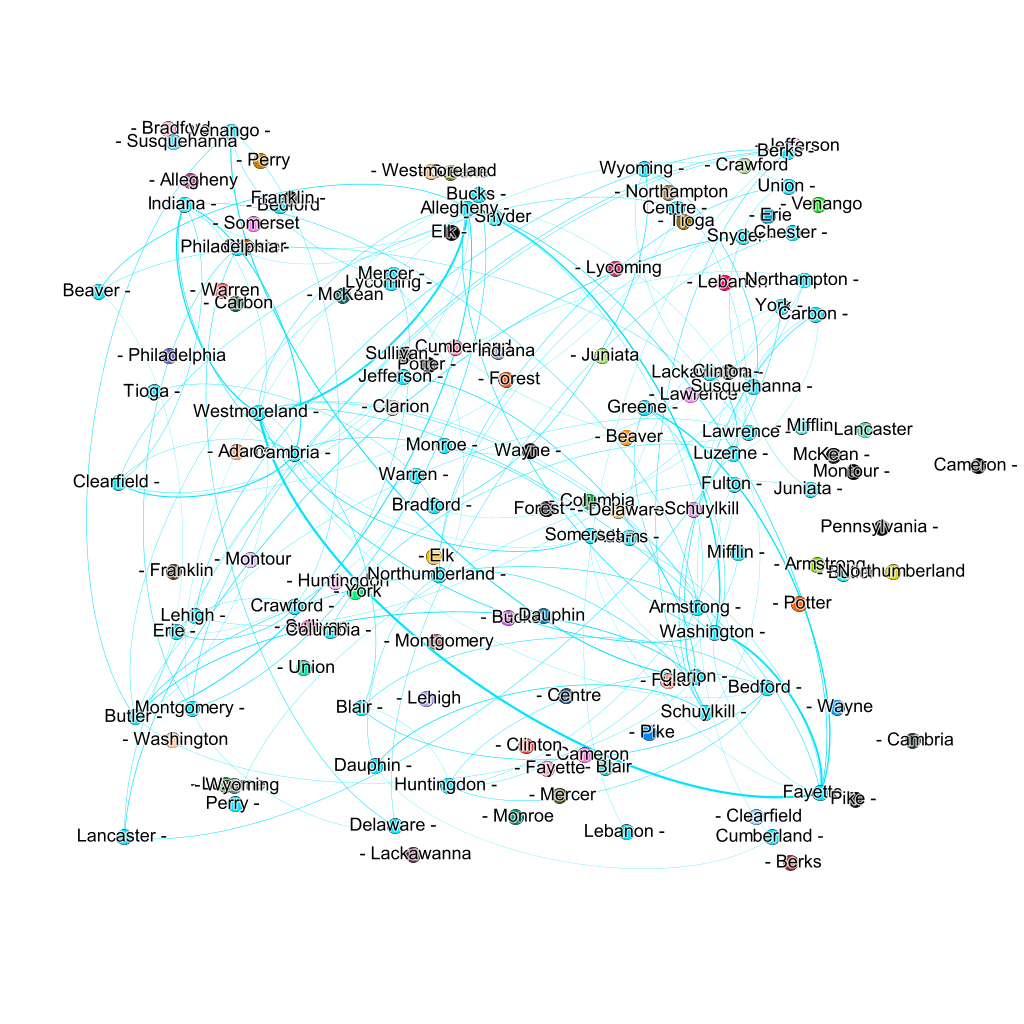

# Factor Exploratory
Now we will import social determinant of health data from: https://www.ahrq.gov/sdoh/data-analytics/sdoh-data.html. We will use 2020 data since the SCI data is from 2020.

In [ ]:
#Read in data
df_sdoh<- read_excel("SDOH_2020_ZIPCODE_1_0.xlsx", sheet = 'Data')
#Select only Pennsylvania zip codes
df_sdoh_pa <- df_sdoh %>% filter(STATE == 'Pennsylvania')

After considering each possible predictor, we have selected predictors that seem like they might have helpful information regarding sci.

In [ ]:
#Select relevant predictors
df_sdoh_pa_selected <- df_sdoh_pa %>% select(3,10, 37, 41, 53, 55, 56, 62, 81, 85, 91, 92, 96, 103, 104, 120, 121, 134, 136, 162, 181, 216, 227, 230, 231, 247, 250, 254, 264, 265, 282, 283, 284, 289, 291, 292, 315, 318)

#Rename ZIP_PA_DIS to df_S
df_s <- ZIP_PA_DIS

#Assign counts to sci data set to assist with merging
df_s <- df_s[order(as.numeric(rownames(df_s))),,drop=FALSE]
df_s$Count <- (1:nrow(df_s))

#Merge sci data and sdoh data by fr_loc zip code
df_sdoh_sci_fr <- merge(df_s, df_sdoh_pa_selected, by.x = 'fr_loc', by.y = 'ZIPCODE')

#Merge sci data and sdoh data by user_loc zip code
df_sdoh_sci_user <- merge(df_s, df_sdoh_pa_selected, by.x = 'user_loc', by.y = 'ZIPCODE')

#Ensure merged data frames are in same order
df_sdoh_sci_user <-df_sdoh_sci_user[order(df_sdoh_sci_user$Count),,drop=FALSE]
df_sdoh_sci_fr <-df_sdoh_sci_fr[order(df_sdoh_sci_fr$Count),,drop=FALSE]

#Find difference between sdoh values for both data frames - a large value indicates zipcodes being very different in respect to that variable, a small one indicates similarity
df_full<- abs(df_sdoh_sci_fr[10:47] - df_sdoh_sci_user[ 10:47])

#Ensure sci data frame is in same order as our new merged sdoh data set
df_s <- df_s[order(df_s$Count),,drop=FALSE]

#Add respective data from sci data frame
df_full$distance <- df_s$distance
df_full$urbrur <- df_s$correlation

#Take log of scaled_sci, from looking at the graphs of data and then the affects on analysis we decided to transform the scaled_sci
df_full$scaled_sci <- log(df_s$scaled_sci)

#Add zipcode lables to full data set
df_full$fr_loc <- df_s$fr_loc
df_full$user_loc <- df_s$user_loc

#Clean the data a little: Drop NAs. Omit any rows with distance = 0. These are sci pairs within the same zipcode, and won't be able to be predicted from differences. This analysis will need to be done separately. 
df_full <- na.omit(df_full)
df_full <- df_full %>% filter(distance > 0)

#Normalize the data
df_normalized <- df_full
for (i in 2:39){
  df_normalized[,i]<-((df_full[,i] - min(df_full[,i]))/((max(df_full[,i])-min(df_full[,i]))))
}

#Let's look a little at the correlations before digging in for further analysis
cor(df_normalized$scaled_sci, df_normalized[2:39])

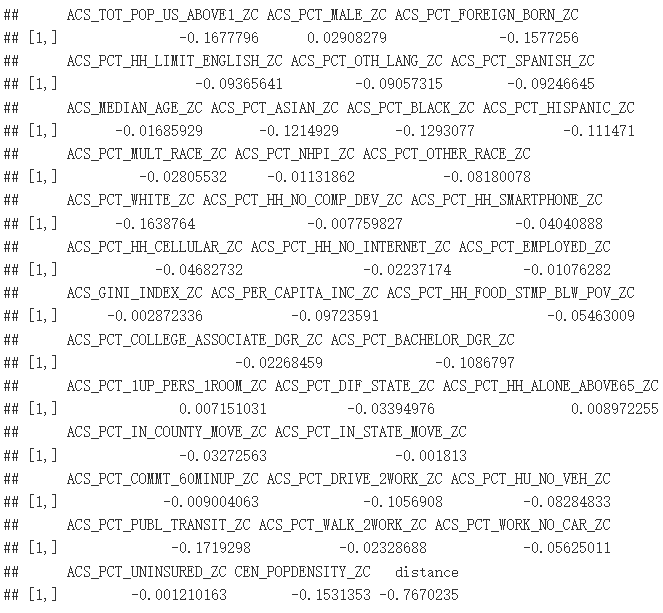

In [ ]:
data <- df_normalized[2:41]

There is a moderately strong negative correlation between distance and sci_scaled. None of the other variables have strong correlations but a few of them have some weak correlations (acs_pct_publ_transit_zc, acs_tot_pop_us_above1_zc, etc.)

In [ ]:
set.seed(2)

#Create a training and test set with an 80/20 split.
test_index <- sample(1:nrow(data), nrow(data)/5)
allnums<- (1:nrow(data))
train_index<- allnums[-test_index]
train <- data[train_index,]
test <- data[test_index,]

Now it is time to start building models. Let’s start by running multiple linear regression with all of the predictors. Since we are using MSE as a way to compare models, we will store all of the MSEs in one MSE list as we go.

In [ ]:
#Run multiple linear regression on all variables and caluculate test predictions
lm.fit <- lm(scaled_sci~., data = train)
predict <- predict.lm(lm.fit, newdata= test)

#Calculate MSE for this model and add to list
MSE.Full.MultiLin <- mean((test$scaled_sci - predict)^2)
MSE.Full.MultiLin

In [ ]:
#Create empty MSE vector and empty vector names for the MSE
MSE_All <- c(MSE.Full.MultiLin)
MSE_Name <- c('Full MLR')

Full linear regression leads to an MSE of 1.032799.

Now we will try forward selection to find the best multiple linear regression model.

In [ ]:
#Fit Models
regfit.fwd <- regsubsets (scaled_sci ~ ., data = train, nvmax = 40 , method = "forward")
test.mat <- model.matrix(scaled_sci ~., data = test)

#Calculate MSE for each model size
val.errors <- rep (NA , 40)
for (i in 1:40) {
  coefi <- coef ( regfit.fwd , id = i)
  pred <- test.mat [, names ( coefi )] %*% coefi
  val.errors [ i] <- mean (( test$scaled_sci - pred ) ^2)
}
val.errors

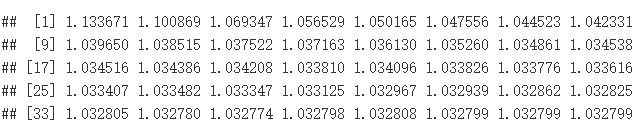

In [ ]:
#Find the model with the smallest MSE
which.min(val.errors)

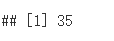

In [ ]:
MSE.Forward <- val.errors[which.min(val.errors)]
MSE.Forward

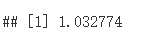

In [ ]:
#Add MSE and Name to lists
MSE_All <- c(MSE_All, MSE.Forward)
MSE_Name <- c(MSE_Name, 'Fwd Select')
names(coef(regfit.fwd, 35))

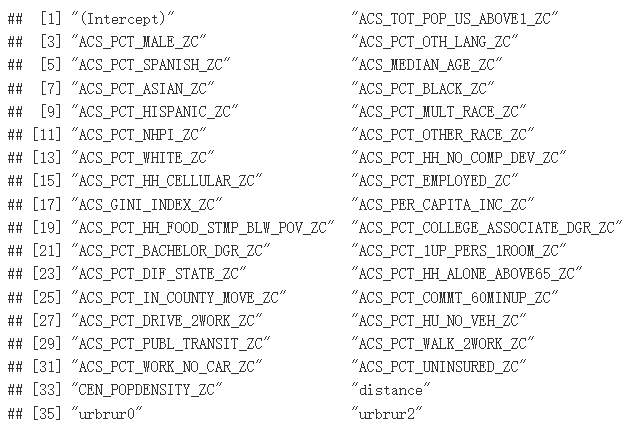

35 predictors minimize the MSE to 1.032774

Let’s look more closely at this model:

In [ ]:
fwd_vars<- which(summary(regfit.fwd, which.min(val.errors))$which[which.min(val.errors),])
fwd_select_data <- subset(data, select = -c(ACS_PCT_FOREIGN_BORN_ZC, ACS_PCT_HH_LIMIT_ENGLISH_ZC, ACS_PCT_HH_SMARTPHONE_ZC, ACS_PCT_HH_NO_INTERNET_ZC, ACS_PCT_HH_NO_INTERNET_ZC))
fwd_train <- fwd_select_data[train_index,]
fwd_test <- fwd_select_data[test_index,]
fwd.fit <- lm(scaled_sci~ . , data = fwd_train)
predict <- predict.lm(fwd.fit, newdata= fwd_test)
summary(fwd.fit)

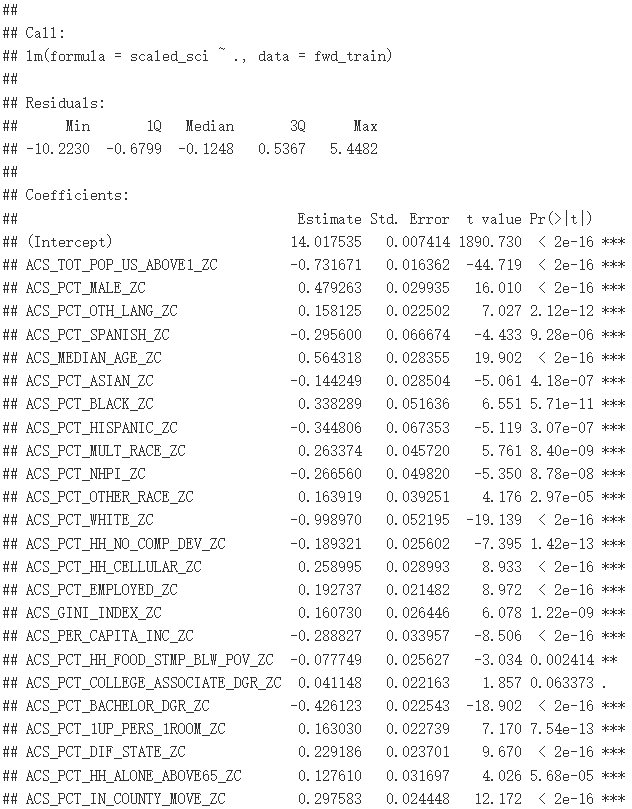
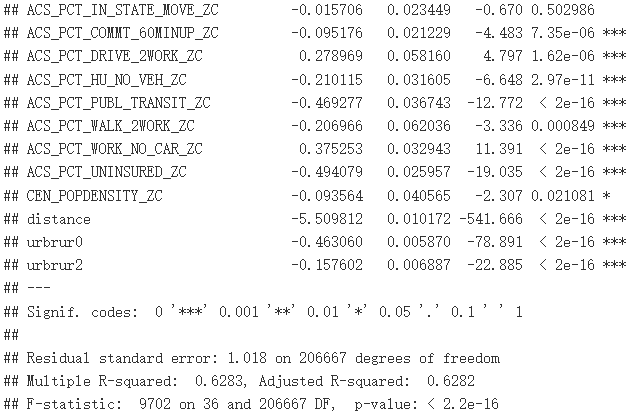

The adjusted R-squared is .6282. In context, this tells us we are able to explain about 63% of the variability of log(scaled_sci) with our predictors. Looking at the estimates of the coefficients, distance seems by far to explain the greatest variability. The other variables contributing most to the model are ACS_PCT_WHITE_ZC and ACS_TOT_POP_US_ABOVE1_ZC.

Next we will run Ridge Regression to see if we can decrease the MSE.

In [ ]:
#Format data and grid to prep for Ridge Regression
x <- model.matrix(scaled_sci~., data)[,-1]
y <- data$scaled_sci
y.test <-y[test_index]
grid <- 10^seq(10, -2, length = 100)

#Fit the Model
ridge.mod <- glmnet(x[train_index,], y[train_index], alpha = 0, lamda = grid, thresh = 1e-12)

set.seed(30)

#Use Cross validation to find best value of lambda
cv.out <- cv.glmnet(x[train_index,], y[train_index], alpha = 0)
plot(cv.out)

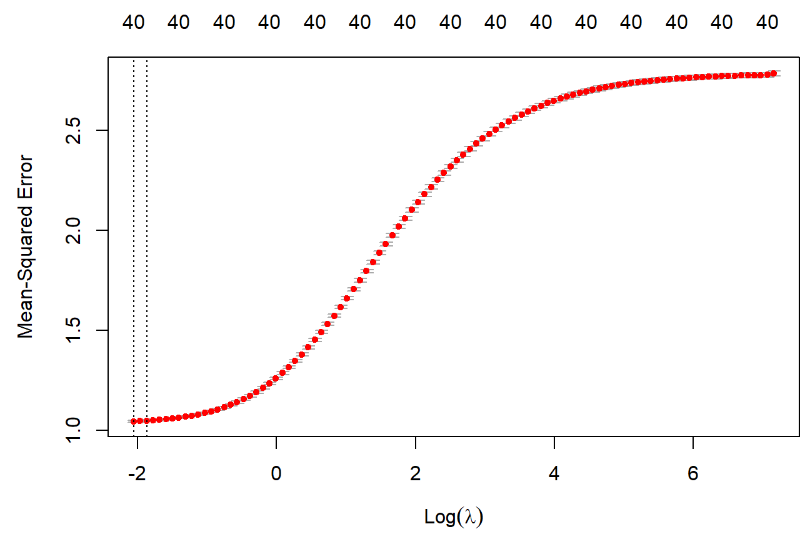

In [ ]:
bestlam <- cv.out$lambda.min
bestlam

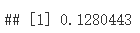

In [ ]:
#Fit predictions with best value of lambda
ridge.pred <- predict(ridge.mod, s = bestlam, newx = x[test_index, ])

#Calculate MSE
MSE.ridge <- mean((ridge.pred - y.test)^2)
MSE.ridge

In [ ]:
#Add MSE and Name to lists
MSE_All <- c(MSE_All, MSE.ridge)
MSE_Name <- c(MSE_Name, 'Ridge')

The ridge MSE is 1.040158, which is actually slightly higher than our forward selection model.

Next we will run Lasso

In [ ]:
#Build the model
lasso.mod <- glmnet(x[train_index, ], y[train_index], alpha =1, lamda = grid)
set.seed(52)

#Use cross validation to select best value of lamda
cv.out <- cv.glmnet(x[train_index, ], y[train_index], alpha = 1)
plot(cv.out)

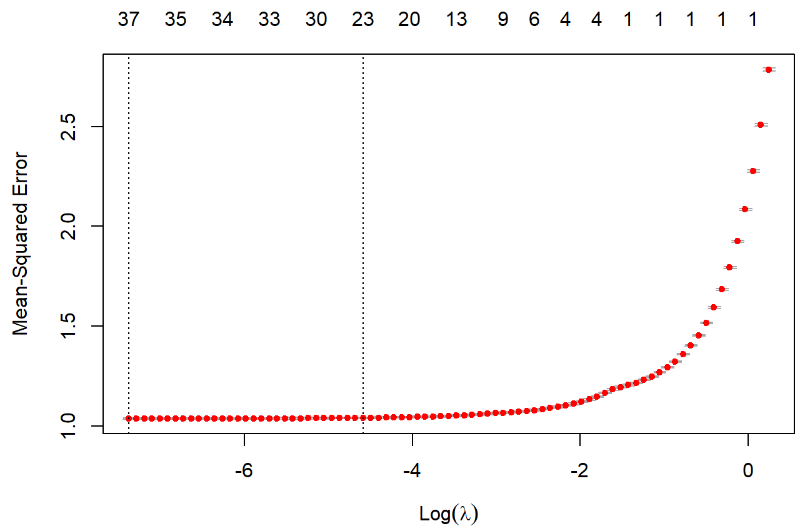

In [ ]:
#Store and report best value for lambda
bestlam <- cv.out$lambda.min 
bestlam

In [ ]:
#Fit predictions for test set using best value of lambda
lasso.pred <- predict(lasso.mod, s = bestlam, newx = x[test_index, ])

#Calculate MSE
MSE.lasso_fwd <- mean((lasso.pred - y.test)^2)

#Look at variables of interest
out <-  glmnet( x, y, alpha = 1, lamda = grid)
lasso.coef <- predict(out, type = 'coefficients', s = bestlam)[1:18,]
lasso.coef

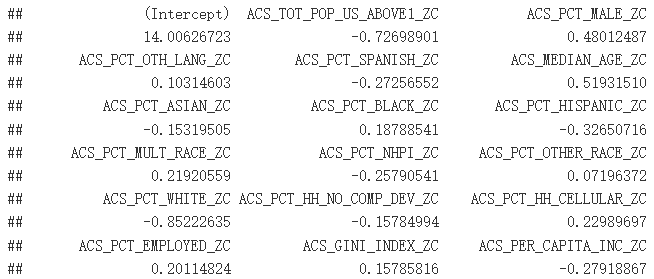

In [ ]:
MSE.lasso_fwd

In [ ]:
#Add MSE and Name to lists
MSE_All <- c(MSE_All, MSE.lasso_fwd)
MSE_Name <- c(MSE_Name, 'Lasso FWD')

The MSE is still larger than that from forward selection ( 1.032839 vs 1.032774)

It is interesting to note that multiple linear regression is out performing Ridge and Lasso. However, since we are using MSE as a model selection criterion, and we are selecting lambda with cross validation, variations in the specific test set would explain these differences especially since Lasso and Ridge also appear to be performing rather similar to multiple linear regression.

Next we will create a tree

In [ ]:
set.seed(77)
#Build and plot the tree
data_tree <- df_full[2:41] %>% filter(distance > 0)
train_tree <- data_tree[train_index,]
test_tree <- data_tree[test_index,]
tree <- tree( scaled_sci ~ ., data_tree, subset = train_index )
plot(tree)
summary(tree)

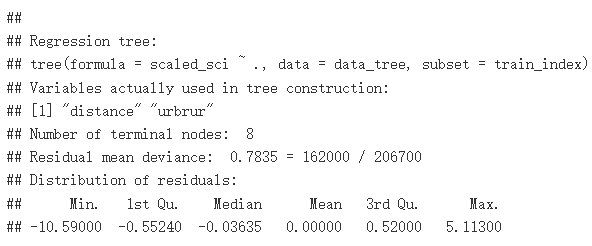

In [ ]:
text(tree, pretty = 0, cex = .5)

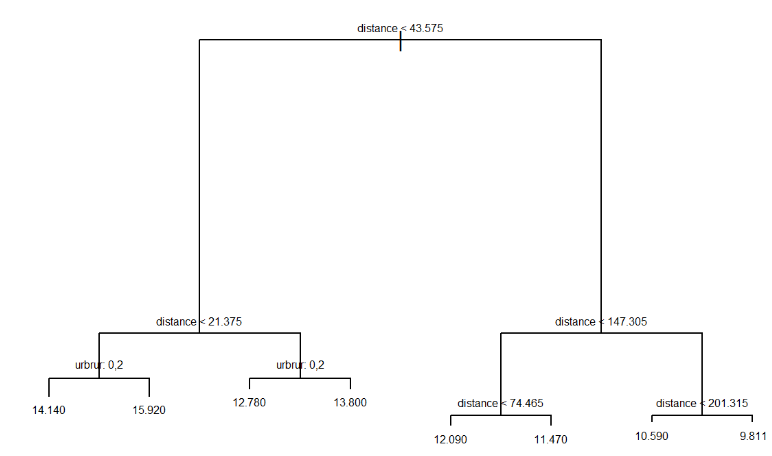

In [ ]:
#Make predictions and calculate MSE
tree.pred <- predict(tree, test_tree)
MSE.tree <- mean((tree.pred - test_tree$scaled_sci)^2)
MSE.tree

In [ ]:
#Add MSE and Name to lists
MSE_All <- c(MSE_All, MSE.tree)
MSE_Name <- c(MSE_Name, 'Full Tree')

In [ ]:
#Run cross validation and plot to see which size is the best
cv.tree <- cv.tree(tree)
plot(cv.tree$size, cv.tree$dev, type = 'b')

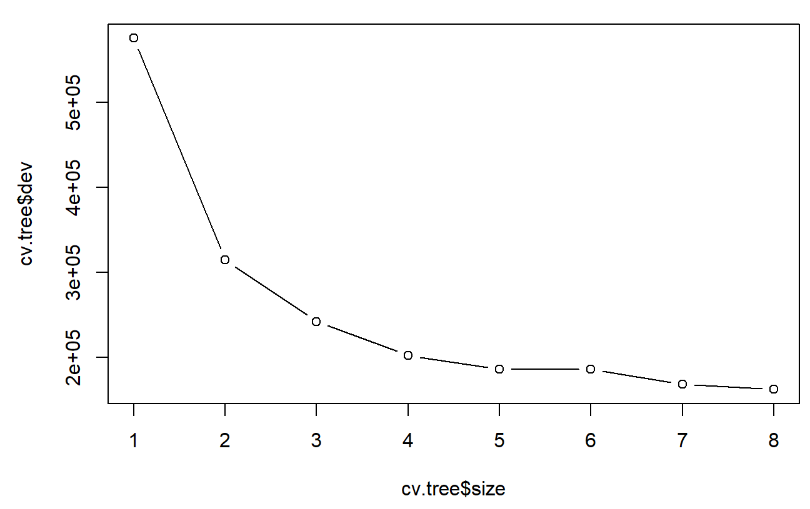

The unpruned tree seems to minimize the MSE, so we will stick with it.

Although we have found the decision tree works bests, let’s look at a graph of all the MSEs of all of the models we tried.

In [ ]:
#Store colors to color code by which model was best
color <- c(rep('Red', 6), 'Green')
MSE_All

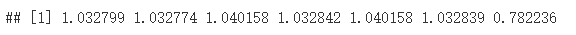

In [ ]:
barplot(MSE_All, names.arg = MSE_Name, las = 2, cex.names = .7, col = color, ylab = 'MSE', xlab = 'Model' )

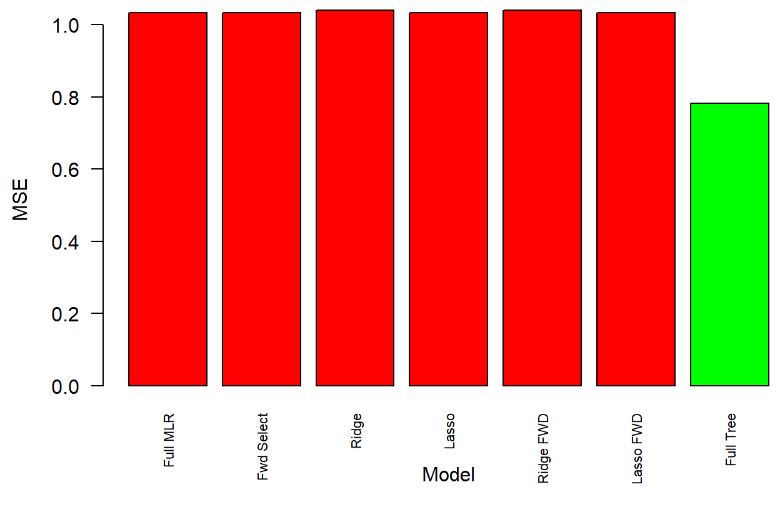

You can see from the graph above that decision tree has the lowest MSE. This suggests that out of all of our models, the tree is the best model and explains the most variability. This model should be better than the model selected through forward selection, suggesting that the tree explains more than 62.82% of the variability in log(scaled_sci). The tree model only uses distance and urban and rural classification. Since this model only has seven nodes, it is relatively intuitive to follow and easy to find the predicted log(scaled_sci) for a new piece of data.

We also need to investigate what causes variability in sci scores within one zip code.

In [ ]:
#Clean the data, selecting only zipcodes pairs with distance of 0 (i.e. the same zipcode twice)
df_same_zip <- df_s %>% filter(distance == 0)

#Merge data with SDOH based on user_loc zipcode
df_same_zip_merged <- merge(df_same_zip, df_sdoh_pa_selected, by.x = 'user_loc', by.y = 'ZIPCODE')

#Select correct variables and omit NAs
same_zip_data <- subset(df_same_zip_merged, select = -c(user_loc, fr_loc, distance, Count, county_fr, county_user, ur_fr, correlation))
same_zip_data <- na.omit(same_zip_data)

#Let's normalize the data
df_normalized_same <- same_zip_data
for (i in 3:39){
  df_normalized_same[,i]<-((same_zip_data[,i] - min(same_zip_data[,i]))/((max(same_zip_data[,i])-min(same_zip_data[,i]))))
}
same_zip_data <- df_normalized_same
cor(same_zip_data$scaled_sci, same_zip_data[3:39])

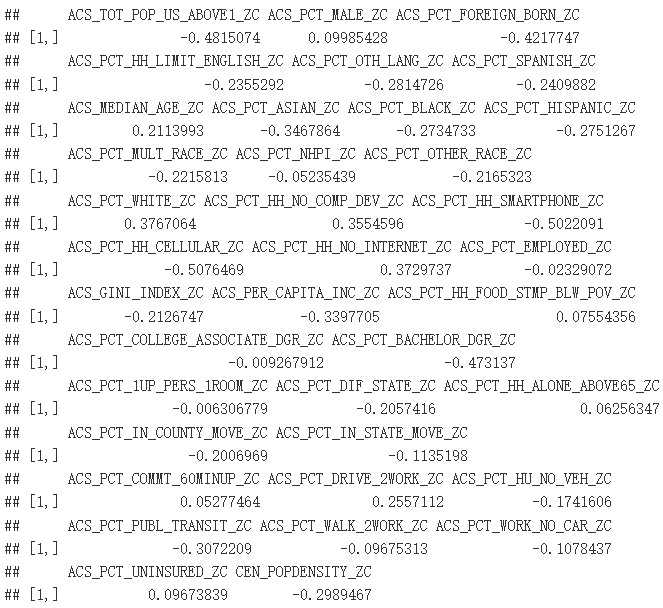

From the below plot, we can see that it might be of worth to take the log of sci.

In [ ]:
plot(same_zip_data$scaled_sci, same_zip_data$ACS_PCT_HH_SMARTPHONE_ZC)

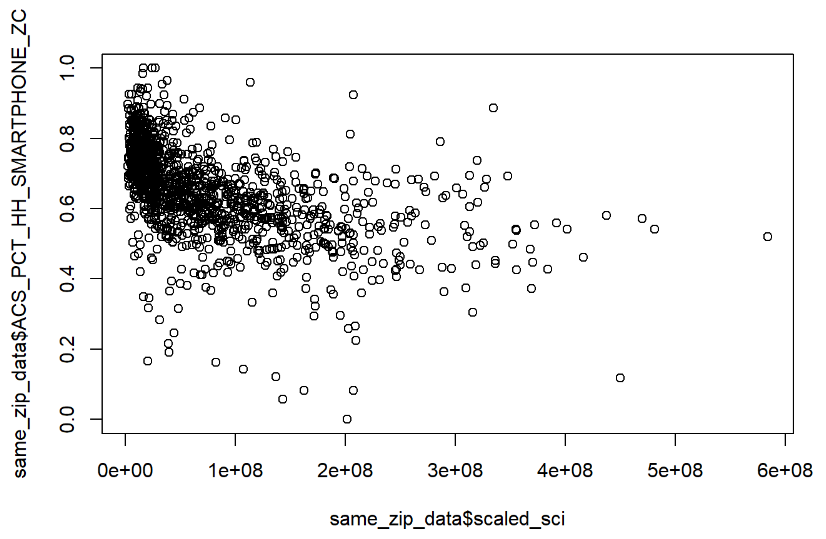

In [ ]:
same_zip_data$scaled_sci <- log(same_zip_data$scaled_sci)

plot(same_zip_data$scaled_sci, same_zip_data$ACS_PCT_HH_SMARTPHONE_ZC)

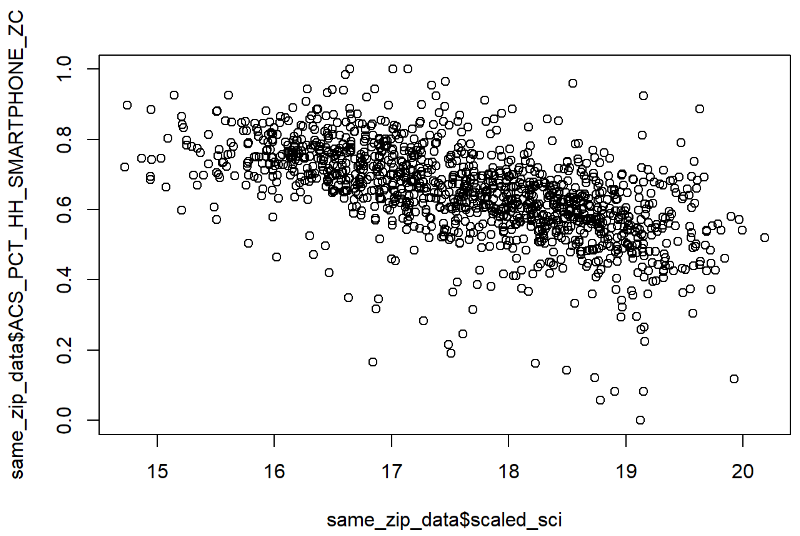

In [ ]:
cor(same_zip_data$scaled_sci, same_zip_data[3:39])

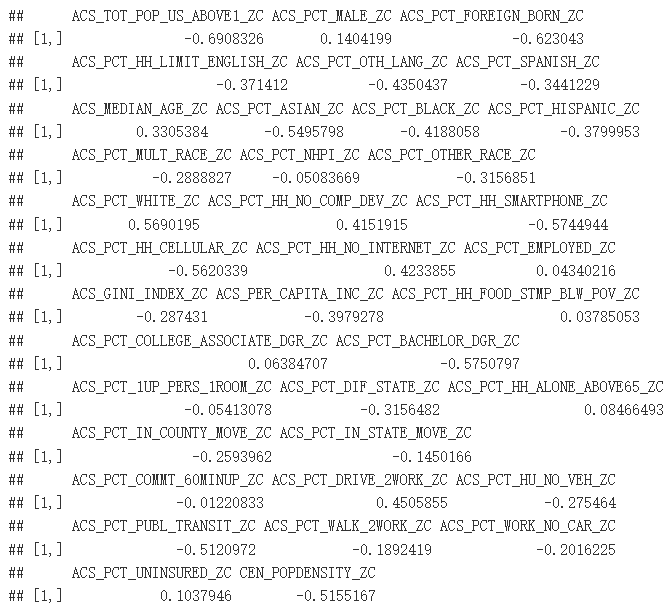

Most of the correlations have increased, which should help us with our model.

In [ ]:
set.seed(18)

#Create a training and test set with an 80/20 split.
test_index_same <- sample(1:nrow(same_zip_data), nrow(same_zip_data)/5)
allnums<- (1:nrow(same_zip_data))
train_index_same<- allnums[-test_index_same]
train_same <- same_zip_data[train_index_same,]
test_same <- same_zip_data[test_index_same,]

Now it is time to start building models. Let’s start by running multiple linear regression with all of the predictors. Since we are using MSE as a way to compare models, we will store all of the MSEs in one MSE list as we go.

In [ ]:
lm.fit_same <- lm(scaled_sci~., data = train_same)
predict <- predict.lm(lm.fit_same, newdata= test_same)

#Calculate MSE for this model and add to list
MSE.Full.MultiLin_same <- mean((test_same$scaled_sci - predict)^2)
MSE.Full.MultiLin_same

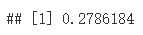

In [ ]:
#Create empty MSE vector and empty vector names for the MSE
MSE_All_Same <- c(MSE.Full.MultiLin_same)
MSE_Name_Same <- c('Full MLR')
summary(lm.fit_same)

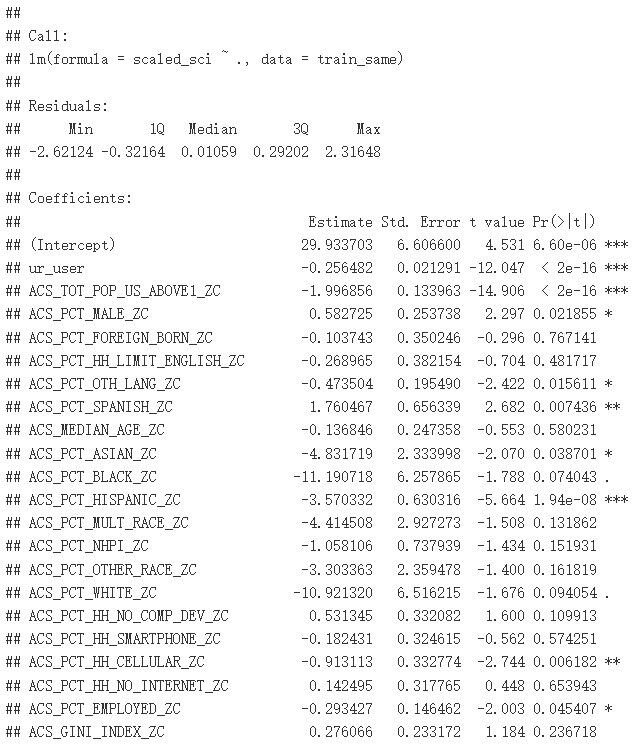
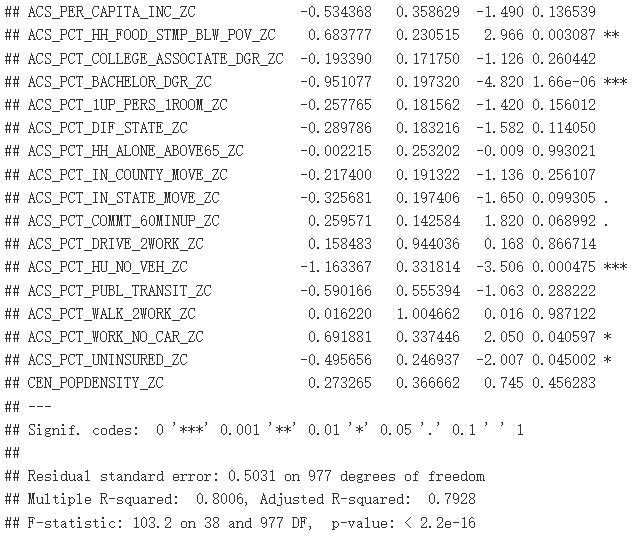

Our MSE for the multiple linear regression is .0008674427

Now we will try forward selection to find the best multiple linear regression model.

In [ ]:
#Fit Models
regfit.fwd_same <- regsubsets (scaled_sci ~ ., data = train_same, nvmax = 37 , method = "forward")
test.mat_same <- model.matrix(scaled_sci ~., data = test_same)
regfit.fwd_same

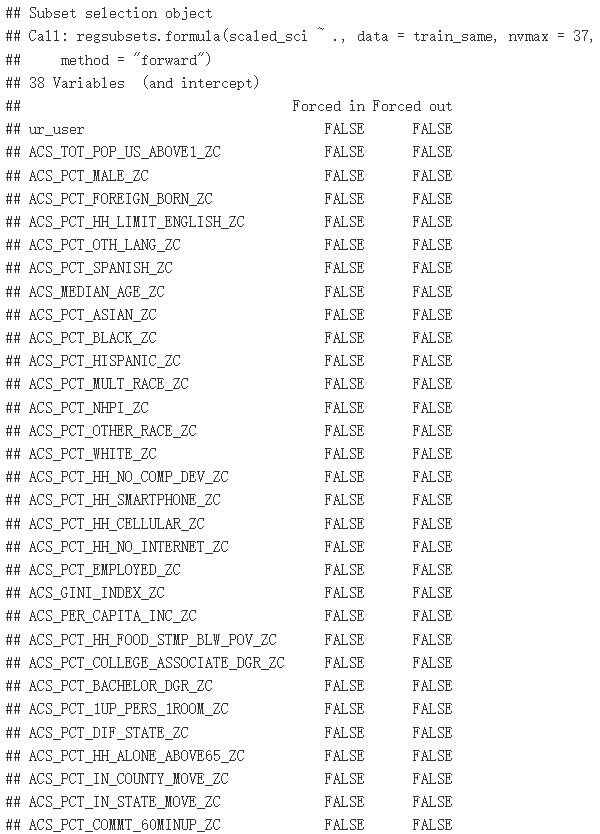
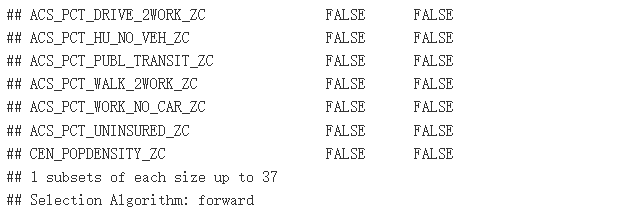

#Calculate MSE for each model size
val.errors_same <- rep (NA , 37)
for (i in 1:37) {
  coefi <- coef ( regfit.fwd_same , id = i)
  pred <- test.mat_same [, names ( coefi )] %*% coefi
  val.errors_same [ i] <- mean (( test_same$scaled_sci - pred ) ^2)
}
val.errors_same

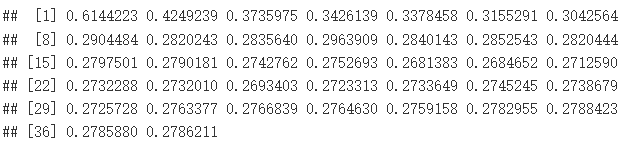

In [ ]:
#Find the model with the smallest MSE
which.min(val.errors_same)

In [ ]:
MSE.Forward_same <- val.errors_same[which.min(val.errors_same)]
MSE.Forward_same

In [ ]:
#Add MSE and Name to lists
MSE_All_Same <- c(MSE_All_Same, MSE.Forward_same)
MSE_Name_Same <- c(MSE_Name_Same, 'Fwd Select')

19 predictors minimize our MSE to 0.2681383

Let’s look more closely at this model

In [ ]:
fwd_same_vars<- which(summary(regfit.fwd_same, which.min(val.errors_same))$which[which.min(val.errors_same),])
fwd_select_data_same <- subset(same_zip_data, select = fwd_same_vars)
fwd_train_same <- fwd_select_data_same[train_index_same,]
fwd_test_same <- fwd_select_data_same[test_index_same,]
fwd.fit_same <- lm(scaled_sci~. , data = fwd_train_same)
predict <- predict.lm(fwd.fit_same, newdata= fwd_test_same)
summary(fwd.fit_same)

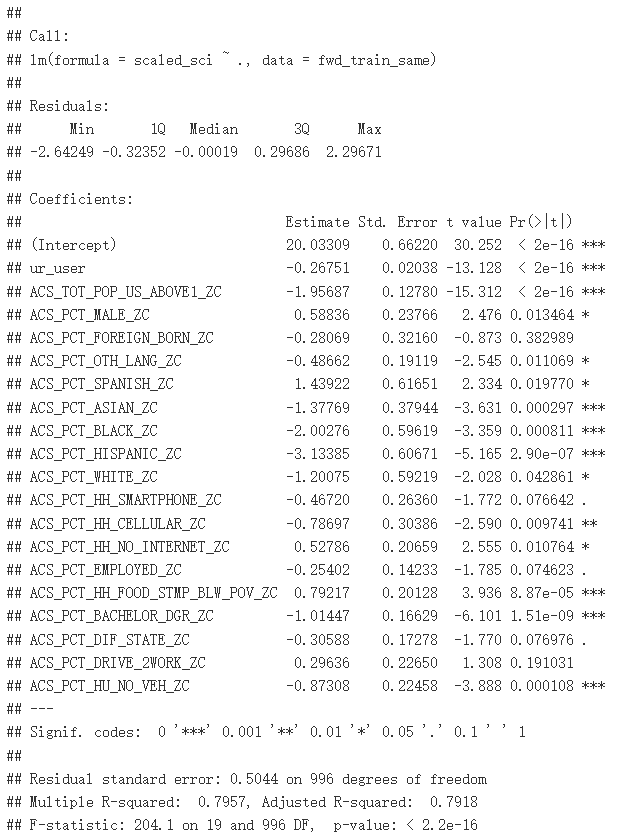

With this model we have a multiple r squared of .7957 and an adjusted R-squared of .7918, meaning we are able to explain about 79% of the variability in log(scaled_sci) with the 19 above predictors. Some of the variables that contribute to the model the most include: ur_user, ACS_TOT_POP_US_ABOVE1_ZC, ACS_PCT_HISPANIC_ZC and ACS_PCT_BACHELOR_DGR_ZC.

Next we will run Ridge Regression on the same zipcodes to see if we can decrease the MSE

In [ ]:
#Format data and grid to prep for Ridge Regression
x <- model.matrix(scaled_sci~., same_zip_data)[,-1]
y <- same_zip_data$scaled_sci
y.test <-y[test_index_same]
grid <- 10^seq(10, -2, length = 100)

#Fit the Model
ridge.mod_same <- glmnet(x[train_index_same,], y[train_index_same], alpha = 0, lamda = grid, thresh = 1e-12)

set.seed(15)

#Use Cross validation to find best value of lambda
cv.out_same <- cv.glmnet(x[train_index_same,], y[train_index_same], alpha = 0)
plot(cv.out_same)

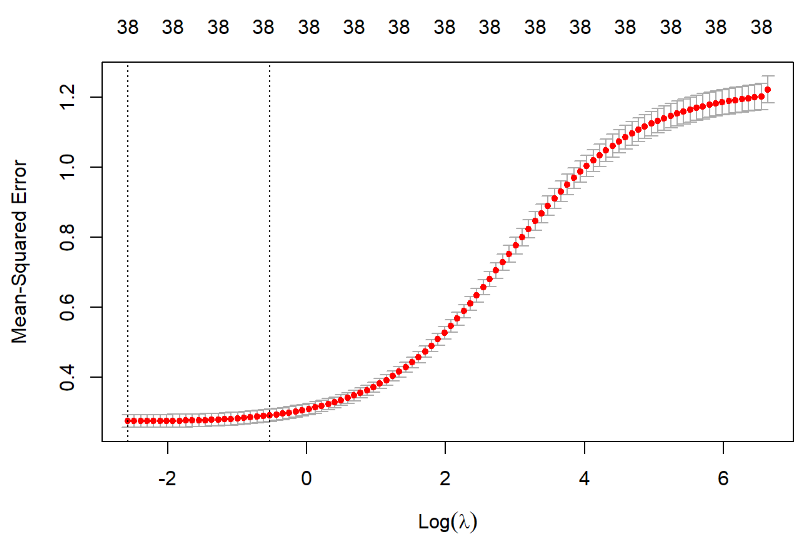

In [ ]:
bestlam_same <- cv.out_same$lambda.min
bestlam_same

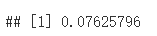

In [ ]:
#Fit predictions with best value of lambda
ridge.pred_same <- predict(ridge.mod_same, s = bestlam_same, newx = x[test_index_same, ])

#Calculate MSE
MSE.ridge_same <- mean((ridge.pred_same - y.test)^2)
MSE.ridge_same

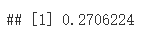

In [ ]:
#Add MSE and Name to lists
MSE_All_Same <- c(MSE_All_Same, MSE.ridge_same)
MSE_Name_Same <- c(MSE_Name_Same, 'Ridge')

Next we will run Lasso

In [ ]:
#Build the model
lasso.mod_same <- glmnet(x[train_index_same, ], y[train_index_same], alpha =1, lamda = grid)
set.seed(117)

#Use cross validation to select best value of lamda
cv.out_same <- cv.glmnet(x[train_index_same, ], y[train_index_same], alpha = 1)
plot(cv.out_same)

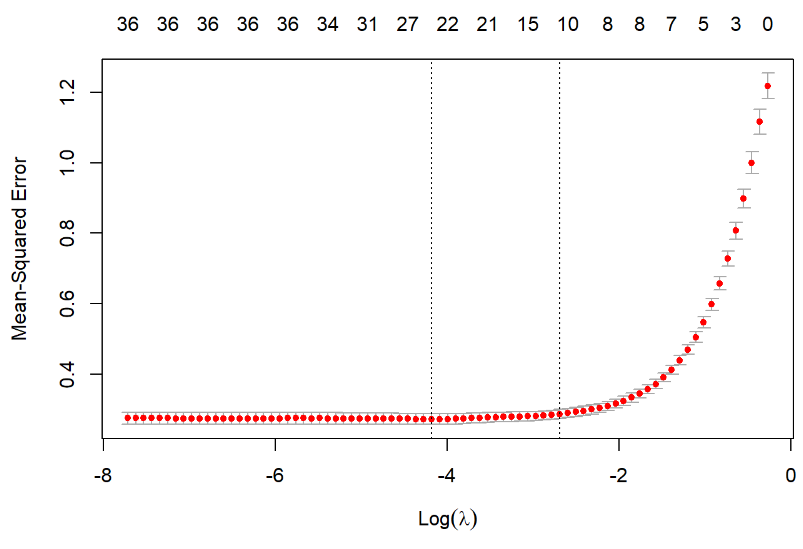

In [ ]:
bestlam_same <- cv.out_same$lambda.min 

#Fit predictions for test set using best value of lambda
lasso.pred_same <- predict(lasso.mod_same, s = bestlam_same, newx = x[test_index_same, ])

#Calculate MSE
MSE.lasso_same <- mean((lasso.pred_same - y.test)^2)

#Look at variables of interest
out <-  glmnet( x, y, alpha = 1, lamda = grid)
lasso.coef <- predict(out, type = 'coefficients', s = bestlam)[1:18,]
lasso.coef

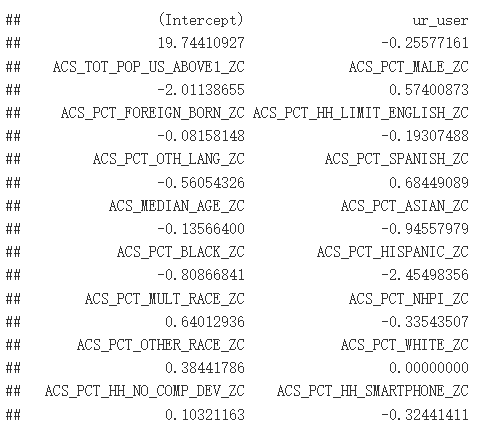

In [ ]:
MSE.lasso_same

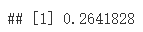

In [ ]:
#Add MSE and Name to lists
MSE_All_Same <- c(MSE_All_Same, MSE.lasso_same)
MSE_Name_Same <- c(MSE_Name_Same, 'Lasso')

Next we will run Ridge Regression but only using the variables selected with forward selection.

In [ ]:
#Format data and grid to prep for Ridge Regression
x <- model.matrix(scaled_sci~., fwd_select_data_same)[,-1]
y <- fwd_select_data_same$scaled_sci
y.test <-y[test_index_same]
grid <- 10^seq(10, -2, length = 100)

#Fit the Model
ridge.mod_same <- glmnet(x[train_index_same,], y[train_index_same], alpha = 0, lamda = grid, thresh = 1e-12)

set.seed(15)

#Use Cross validation to find best value of lambda
cv.out_same <- cv.glmnet(x[train_index_same,], y[train_index_same], alpha = 0)
plot(cv.out_same)

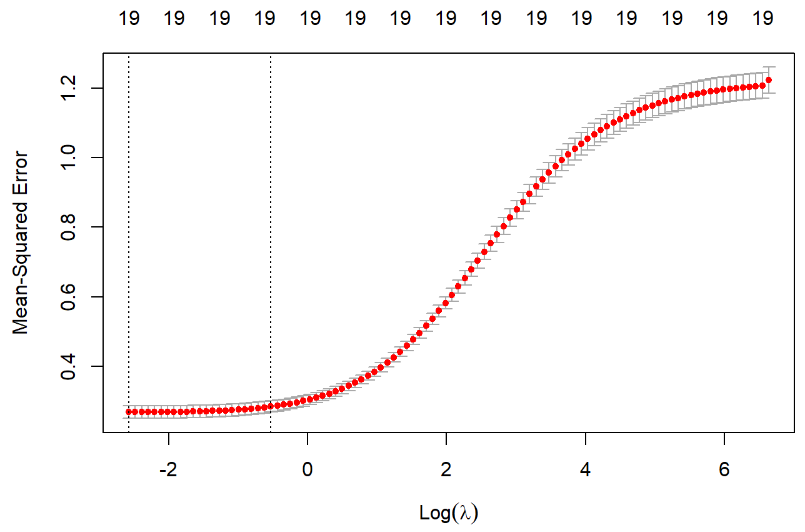

In [ ]:
bestlam_same_fwd <- cv.out_same$lambda.min
bestlam_same_fwd

In [ ]:
#Fit predictions with best value of lambda
ridge.pred_same <- predict(ridge.mod_same, s = bestlam_same_fwd, newx = x[test_index_same, ])

#Calculate MSE
MSE.ridge_same_fwd <- mean((ridge.pred_same - y.test)^2)
MSE.ridge_same_fwd

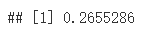

In [ ]:
#Add MSE and Name to lists
MSE_All_Same <- c(MSE_All_Same, MSE.ridge_same_fwd)
MSE_Name_Same <- c(MSE_Name_Same, 'Ridge FWD')

Next we will run Lasso

In [ ]:
#Build the model
lasso.mod_same <- glmnet(x[train_index_same, ], y[train_index_same], alpha =1, lamda = grid)
set.seed(117)

#Use cross validation to select best value of lambda
cv.out_same <- cv.glmnet(x[train_index_same, ], y[train_index_same], alpha = 1)
plot(cv.out_same)

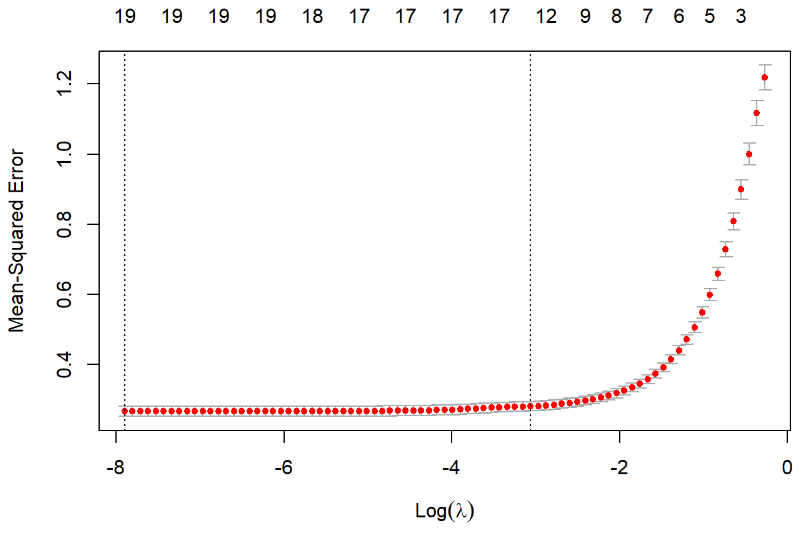

In [ ]:
bestlam_same <- cv.out_same$lambda.min 

#Fit predictions for test set using best value of lambda
lasso.pred_same <- predict(lasso.mod_same, s = bestlam_same, newx = x[test_index_same, ])

#Calculate MSE
MSE.lasso_same_fwd <- mean((lasso.pred_same - y.test)^2)

#Look at variables of interest
out <-  glmnet( x, y, alpha = 1, lamda = grid)
lasso.coef <- predict(out, type = 'coefficients', s = bestlam)[1:18,]
lasso.coef

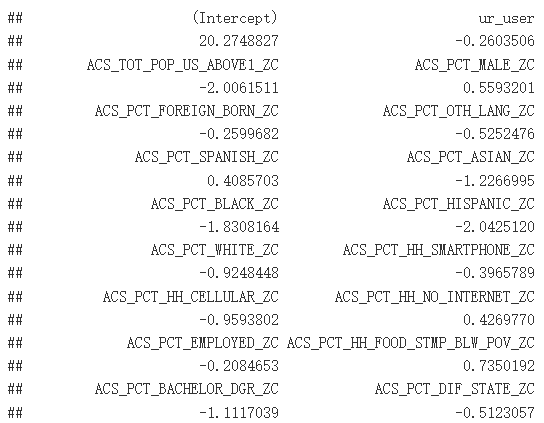

In [ ]:
MSE.lasso_same_fwd

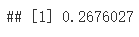

In [ ]:
#Add MSE and Name to lists
MSE_All_Same <- c(MSE_All_Same, MSE.lasso_same_fwd)
MSE_Name_Same <- c(MSE_Name_Same, 'Lasso Fwd')

Next we will create a tree

In [ ]:
Next we will create a tree

set.seed(77)
#Build and plot the tree
tree_same <- tree( scaled_sci ~ ., same_zip_data, subset = train_index_same )
plot(tree_same)
summary(tree_same)

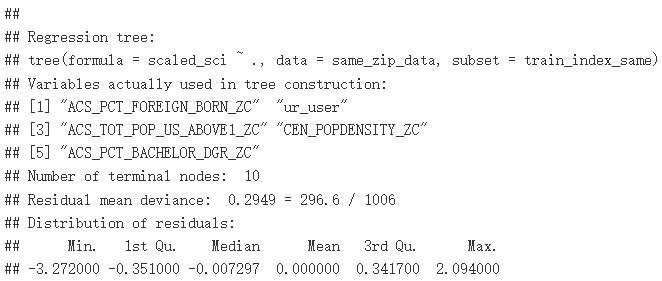

In [ ]:
text(tree_same, pretty = 0, cex = .5)

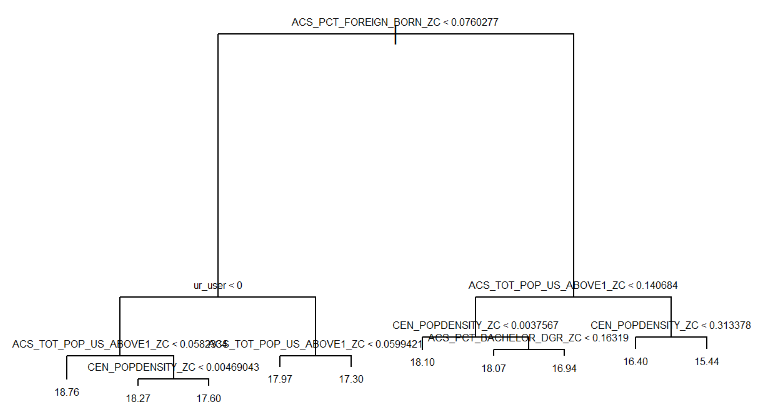

In [ ]:
#Make predictions and calculate MSE
tree.pred_same <- predict(tree_same, test_same)
MSE.tree_same <- mean((tree.pred_same - test_same$scaled_sci)^2)
MSE.tree_same

In [ ]:
#Add MSE and Name to lists
MSE_All_Same <- c(MSE_All_Same, MSE.tree_same)
MSE_Name_Same <- c(MSE_Name_Same, 'Full Tree')

Although we have found the decision tree works bests, let’s look at a graph of all the MSEs of all of the models we tried.

In [ ]:
color <- c(rep('Red', 3), 'Green', rep('Red', 4))
barplot(MSE_All_Same, names.arg = MSE_Name_Same, las = 2, cex.names = .7, col = color, ylab = 'MSE within Zipcodes', xlab = 'Model' )

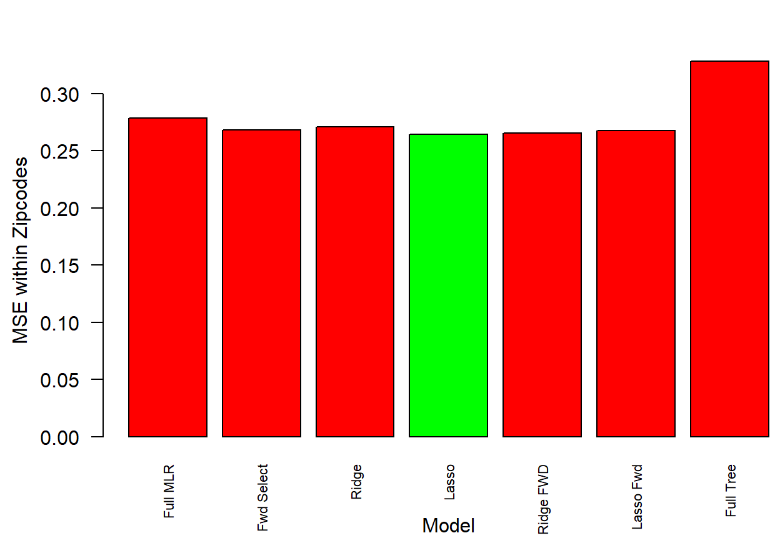

In [ ]:
which.min(MSE_All_Same)

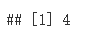

You can see from the above graph that Lasso on all the variables has the lowest MSE and therefore explains the most variability. However, it is rather similar to the multiple linear regression model that was selected with forward selection.As such, for interpretability purposes, we might want to stick with using the forward selection model to explain variability. This model uses ur_user, ACS_TOT_POP_US_ABOVE1_ZC, ACS_PCT_MALE_ZC, ACS_PCT_FOREIGN_BORN_ZC, ACS_PCT_OTH_LANG_ZC, ACS_PCT_SPANISH_ZC, ACS_PCT_ASIAN_ZC, ACS_PCT_BLACK_ZC, ACS_PCT_HISPANIC_ZC, ACS_PCT_WHITE_ZC, ACS_PCT_HH_SMARTPHONE_ZC, ACS_PCT_HH_CELLULAR_ZC, ACS_PCT_HH_NO_INTERNET_ZC, ACS_PCT_EMPLOYED_ZC, ACS_PCT_HH_FOOD_STMP_BLW_POV_ZC, ACS_PCT_BACHELOR_DGR_ZC, ACS_PCT_DIF_STATE_ZC, ACS_PCT_DRIVE_2WORK_ZC, and ACS_PCT_HU_NO_VEH_ZC to explain approximately 79% of the variability in log(scaled_sci).

If we were to try to interpret the lasso model, which has a lower MSE we would use the following variables:                     ur_user, ACS_TOT_POP_US_ABOVE1_ZC, ACS_PCT_MALE_ZC, ACS_PCT_FOREIGN_BORN_ZC, ACS_PCT_HH_LIMIT_ENGLISH_ZC, ACS_PCT_OTH_LANG_ZC, ACS_PCT_SPANISH_ZC, ACS_MEDIAN_AGE_ZC, ACS_PCT_ASIAN_ZC, ACS_PCT_BLACK_ZC, ACS_PCT_HISPANIC_ZC, ACS_PCT_MULT_RACE_ZC, ACS_PCT_NHPI_ZC, ACS_PCT_OTHER_RACE_ZC, ACS_PCT_WHITE_ZC, ACS_PCT_HH_NO_COMP_DEV_ZC, and ACS_PCT_HH_SMARTPHONE_ZC. These variables work together in the model to explain a little more than the variability in log(scaled_sce) than the multiple linear regression model chosen through forward selection.

## Conclusions and Implications of Sci Variability

The above analysis was very exploratory in nature. Our goal was not to predict SCI, but to explain the variability behind it. One of the biggest driving factors in our analysis was the distance between two zipcodes. When focusing on distances greater than 0, distance was one of the biggest contributing factors in our models. This makes sense since people are more likely to be socially connected with people they have met in person or who have a similar connection, such as hometown as them. Urban and rural classification also seemed to be a helpful predictor, being the only other variable to make it into the distance decision tree. 

When we did some exploration on factors that could cause higher social conectivity scores within one zipcode, we saw that various social determinants of health as well as urban/rural classification were helpful in explaining variability. We also were able to produce more accurate models with higher adjusted r-squared when working with this subset of the data. This makes sense in context because the data and the relationship of the variables is less complicated than between two different zipcodes.

Also, it is important to note, that we are explaining the variability in log(scaled_sci) in all of our models, which further complicates interpretation of what the models are telling us in context.

Overall we considered a lot of different factors to help explain the variability, but still cannot explain the variability anywhere near perfectly. This speaks to how complicated human beings are. It can be really hard to capture human connection and to capture human motivation, especially when we often struggle to understand our indiviual motivations ourselves. The difficulty we had explaining variability gives an interesting insight into the complexity of human nature and human relationships. 


## Create the dataset of census tract - census tract

In [ ]:
ZIP_PA <- ZIP %>% 
  filter(user_loc %in% 15001:19612 & fr_loc %in% 15001:19614) %>%
  distinct(scaled_sci,.keep_all = TRUE)

ZIP_DATA <- as.data.frame(reverse_zipcode(ZIP_PA_DISTANCE$user_loc))

data(zcta_crosswalk)

ZIP_CT <- merge(ZIP_PA,zcta_crosswalk, by.x = 'user_loc', by.y = 'ZCTA5') %>%
  select(-TRACT) %>%
  plyr::rename(c('GEOID'='user_geoid'))

zcta_n <- zcta_crosswalk %>% 
  count(ZCTA5)

ZIP_CT <- merge(ZIP_CT,zcta_n, by.x = 'user_loc', by.y = 'ZCTA5')

ZIP_CT <- ZIP_CT %>%
  mutate('new_sci' = scaled_sci/n)

ZIP_CT <- merge(ZIP_CT, zcta_crosswalk, by.x = 'fr_loc', by.y = 'ZCTA5') %>%
  plyr::rename(c('GEOID'='fr_geoid')) %>%
  select(-TRACT)

ZIP_CT <-  ZIP_CT %>%
  group_by(user_geoid,fr_geoid) %>%
  summarise(user_geoid, fr_geoid,sci = sum(new_sci)) %>%
  distinct()

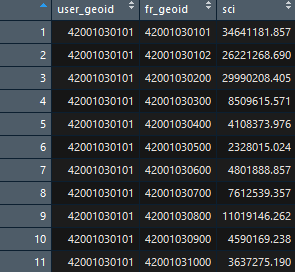